In [1]:
using Lux
using Zygote
using Optimization
using OptimizationOptimisers
using Random
using Statistics
using DifferentialEquations
using Plots
using ComponentArrays
using NNlib

### True ODE Model and Synthetic Data Generation

In [40]:
struct SIR_params
    β::Float32
    γ::Float32
end

# SIR model method for DifferentialEquations call 
function SIR_model!(du, u, p::SIR_params, t)
    S, I, R = u
    du[1] = -p.β * S * I 
    du[2] =  p.β * S * I - p.γ * I
    du[3] =  p.γ * I
end

# SIR model non mutating function method to calculate NN RHS
SIR_model(y::AbstractMatrix{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1, :] .* y[2, :]        
    dI = p.β .* y[1,:] .* y[2, :] - p.γ .* y[2, :]
    dR = p.γ .* y[2, :]                         
    permutedims(hcat(dS, dI, dR))
end

SIR_model(y::AbstractVector{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1] .* y[2]        
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end


# Fast default RNG. Does not get messed up with a global RNG
rng = Random.MersenneTwister(42)

true_SIR_par = SIR_params(0.30, 0.1)
t_span = (0.0, 60.0)
N_obs = 101

# Collect seems to turn an iterable into an array
t_obs_array = range(t_span[1], t_span[2], length=N_obs) |> collect
u0 = [0.999, 0.001, 0.0]

prob = DifferentialEquations.ODEProblem(SIR_model!, u0, t_span, true_SIR_par)
sol = DifferentialEquations.solve(
    prob,
    DifferentialEquations.Tsit5();
    saveat = t_obs_array
)
sol_ = Array(sol)

# --- multiplicative % noise via lognormal, unbiased & positive ---
noise_pct = 0.2
ε = Random.randn(rng, size(sol_)...)
noisy_data = sol_ .* exp.(noise_pct .* ε .- 0.5 * noise_pct^2)
noisy_data = clamp.(noisy_data, 0, Inf32)

# Convert to Float32 to keep everyone happy
t_train = Float32.(t_obs_array)
Y_train = Float32.(noisy_data)
y0_obs  = Y_train[:, 1]     # IC for penalty
Y_train_std = Statistics.std(Y_train, dims=2)


3×1 Matrix{Float32}:
 0.39722162
 0.11136482
 0.29236832

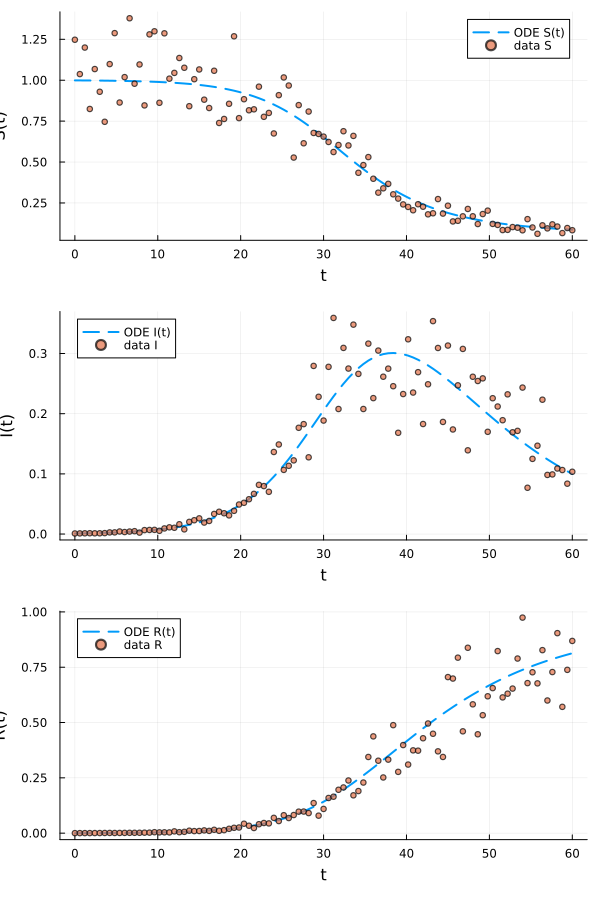

In [29]:

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))


# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

### Setting up the NN

In [35]:
#= NN_model = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3,)
) =#

NN_model = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3, NNlib.softplus) # forces outputs to be positive
)

ps, st = Lux.setup(rng, NN_model)
ps = ComponentArrays.ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (weight = Float32[-2.4554863; -2.4619243; … ; 0.6476267; 2.6869864;;], bias = Float32[0.8713901, 0.7082715, 0.24116898, -0.98409796, 0.5418849, -0.07589269, 0.73667765, -0.026423216, 0.8068354, 0.49735236]), layer_2 = (weight = Float32[-0.09921343 0.025378974 … -0.6335 -0.61962205; -0.82500285 0.5330612 … -0.13733728 0.80092496; … ; -0.43876874 0.23977752 … 0.2589436 0.56984633; -0.8282025 0.42641735 … -0.0038288175 0.69928545], bias = Float32[-0.28525034, -0.10210936, 0.0057555465, -0.18929903, 0.2826747, -0.29175943, 0.09967299, 0.25919804, 0.14594452, 0.29753858]), layer_3 = (weight = Float32[0.5058591 -0.008731455 … -0.113023646 0.20341678; 0.08726087 0.06052601 … -0.40646818 0.025772829; -0.07373295 0.09640629 … 0.2426068 0.45053473], bias = Float32[0.16706517, -0.0974542, -0.14050774]))

### Computing Loss

In [53]:
function MSE(ŷ, y)
    Statistics.mean(abs2, vec(ŷ .- y))
end

function MSE(ŷ, y, denom)
    t = vec((ŷ - y)./denom)
    Statistics.mean(abs2, t)
end

λ_ic = 1.0f0*10
λ_ode = 1.0f0*2

function loss_supervised(ps, ctx)
    #ctx is a named tuple holding everything non-trainable
    model = ctx.model
    st = ctx.st
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    y0_obs = ctx.y0_obs
    λ_ic = ctx.λ_ic
    λ_ode = ctx.λ_ode
    SIR_par = ctx.SIR_par
    Y_train_std = ctx.Y_train_std
    
    smodel = Lux.StatefulLuxLayer(model, ps, st)
    ŷ = smodel(t_train')
    data_mse = MSE(ŷ, Y_train, Y_train_std)
    ic_mse = MSE(ŷ[:,1], y0_obs, Y_train_std)

    return data_mse + ic_mse *λ_ic
end

t_dense = Float32.(range(t_train[begin], t_train[end], length=200) |> collect)
ctx = (
    model = NN_model,
    st = st,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    y0_obs = y0_obs,
    λ_ic = λ_ic,
    λ_ode = λ_ode,
    t_dense = t_dense,
    SIR_par = true_SIR_par

)

(model = Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(softplus), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 10, tanh), layer_2 = Dense(10 => 10, tanh), layer_3 = Dense(10 => 3, softplus)), nothing), st = (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()), t_train = Float32[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, 5.4  …  54.6, 55.2, 55.8, 56.4, 57.0, 57.6, 58.2, 58.8, 59.4, 60.0], Y_train = Float32[1.2473931 1.0374839 … 0.096619084 0.0833346; 0.0009648335 0.0010902366 … 0.0836962 0.10350551; 0.0 7.0643284f-5 … 0.73810965 0.86885494], Y_train_std = Float32[0.39722162; 0.11136482; 0.29236832;;], y0_obs = Float32[1.2473931, 0.0009648335, 0.0], λ_ic = 10.0f0, λ_ode = 2.0f0, t_dense = Float32[0.0, 0.30150753, 0.60301507, 0.9045226, 1.2060301, 1.5075377, 1.8090452, 2.1105528, 2.4120603, 2.

### Optimization

In [54]:

optfun = Optimization.OptimizationFunction(
    (x, p) -> loss_supervised(x,p),
    Optimization.AutoZygote()
)
prob_fit = Optimization.OptimizationProblem(optfun, ps, ctx)
res = Optimization.solve(prob_fit, OptimizationOptimisers.Adam(1e-03); maxiters=5_000)
ps_trained = res.u

ComponentVector{Float32}(layer_1 = (weight = Float32[-2.6641462; -0.057181954; … ; 1.1263552; 0.0133557115;;], bias = Float32[0.72483677, 0.98004293, 0.549541, -0.99159044, 0.8390591, -0.3947402, 0.53862953, -0.3378117, 1.0711186, 0.43230298]), layer_2 = (weight = Float32[-0.33035338 -0.17320971 … -0.7869164 -0.77236134; -1.0304275 0.19574897 … -0.42609861 0.54141206; … ; -0.26029125 0.42100745 … 0.48980314 0.7947273; -0.77074957 0.9210201 … 0.10474267 0.70596886], bias = Float32[-0.44227424, -0.37018594, -0.19478483, -0.3976288, 0.48606116, -0.10937771, -0.001039532, 0.04009267, 0.35920787, 0.39243895]), layer_3 = (weight = Float32[0.4842981 -0.39439496 … -0.42581472 0.8464862; 0.41599104 0.50762445 … -0.6474338 -0.24410091; 0.3007723 1.0338858 … -0.22010759 -0.39183828], bias = Float32[0.23943937, -0.33850107, -0.47587472]))

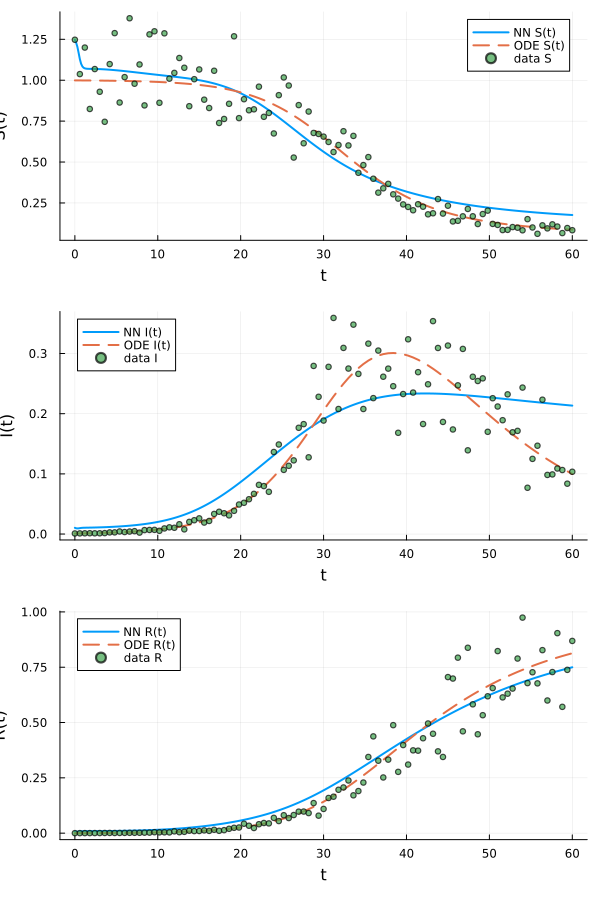

In [55]:
# Build a stateful model bound to the trained params
smodel = Lux.StatefulLuxLayer(NN_model, ps_trained, st)

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))

# NN predictions on the smooth grid (3×N)
ŷ_plot = smodel(permutedims(t_plot))  # 1×N input expected; returns 3×N

# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_nn,   I_nn,   R_nn   = vec(ŷ_plot[1, :]), vec(ŷ_plot[2, :]), vec(ŷ_plot[3, :])
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_plot, S_nn; label = "NN S(t)", linewidth = 2)
Plots.plot!(p1, t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_plot, I_nn; label = "NN I(t)", linewidth = 2)
Plots.plot!(p2, t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_plot, R_nn; label = "NN R(t)", linewidth = 2)
Plots.plot!(p3, t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)
